ROC AUC Score: 0.5527747325845144
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.10      0.16      8299
           1       0.60      0.94      0.73     11803

    accuracy                           0.59     20102
   macro avg       0.56      0.52      0.45     20102
weighted avg       0.57      0.59      0.50     20102



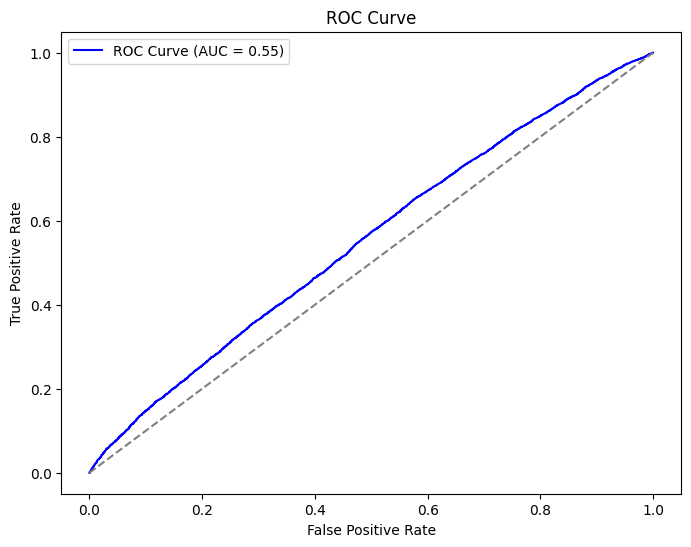

Predicted Probability of Profit: [0.7355396  0.66570413 0.5832805 ]


In [47]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define categorization functions
def categorize_rsi(rsi):
    
    if 0 < rsi <= 50:
        return '0-50'
    elif 50 < rsi <= 80:
        return '50-80'
    else:
        return '100-80'  # Assuming the category represents overbought RSI values

def categorize_volume_multiple(volume):
    if volume < 5.5:
        return 'low volume'
    elif 5.5 <= volume < 8:
        return 'normal volume'
    else:
        return 'very high volume'

# Convert 'Market cap' from lakhs to billions
data['Market cap'] = data['Market cap'] * 1e5 / 1e9  # Convert from lakhs to billions

def categorize_market_cap(market_cap):
    if market_cap > 20:  # Greater than 10 billion
        return 'Large Cap'
    elif 10 <= market_cap <= 20:  # Between 2 billion and 10 billion
        return 'Large-Mid Cap'
    elif 2 <= market_cap <= 10:  # Between 2 billion and 10 billion
        return 'Mid Cap'
    else:  # Less than 2 billion
        return 'Small Cap'

# Load and preprocess the data
file_path = 'master_data.csv'
data = pd.read_csv(file_path)

# Data preprocessing steps
data['Market cap'] = pd.to_numeric(data['Market cap'].str.replace(',', ''), errors='coerce')
data['RSI'] = pd.to_numeric(data['RSI'], errors='coerce')
data['Volume Multiple'] = pd.to_numeric(data['Volume Multiple'], errors='coerce')
data['Trade Result'] = data['Trade Result'].apply(lambda x: 1 if x == 'Profit' else 0)

# Handle missing or infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
data.dropna(inplace=True)  # Drop rows with NaN values

# Feature engineering
data['RSI Category'] = data['RSI'].apply(categorize_rsi)
data['Volume Multiple Category'] = data['Volume Multiple'].apply(categorize_volume_multiple)
data['Market Cap Category'] = data['Market cap'].apply(categorize_market_cap)

# Encode categorical features using one-hot encoding
data = pd.get_dummies(data, columns=['RSI Category', 'Volume Multiple Category', 'Market Cap Category'], drop_first=True)

# Select features and target variable
features = ['RSI', 'Volume Multiple', 'Market cap'] + [col for col in data.columns if col.startswith(('RSI Category_', 'Volume Multiple Category_', 'Market Cap Category_'))]
X = data[features]
y = data['Trade Result']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost model
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities of profit
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Classification Report:")
print(classification_report(y_test, model.predict(X_test)))

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Aligning new data columns with training features
new_data = pd.DataFrame({
    'RSI': [55, 85, 25],
    'Volume Multiple': [1.5, 3.2, 0.8],
    'Market cap': [2000, 50000, 800],
})

# Apply the same preprocessing to new data
new_data['RSI Category'] = new_data['RSI'].apply(categorize_rsi)
new_data['Volume Multiple Category'] = new_data['Volume Multiple'].apply(categorize_volume_multiple)
new_data['Market Cap Category'] = new_data['Market cap'].apply(categorize_market_cap)

# Encode categorical features in new data to match training data
new_data = pd.get_dummies(new_data, columns=['RSI Category', 'Volume Multiple Category', 'Market Cap Category'])

# Align columns of new data with training data by reindexing
new_data = new_data.reindex(columns=X_train.columns, fill_value=0)

# Predict the probability of profit for new data
predicted_prob = model.predict_proba(new_data)[:, 1]
print("Predicted Probability of Profit:", predicted_prob)


In [46]:
# Load and preprocess the new data from test_data.csv
new_data_path = 'test_data.csv'
new_data = pd.read_csv(new_data_path)

# Store original columns for final output
original_columns = new_data.copy()

# Apply the same preprocessing to new data
new_data['Market cap'] = pd.to_numeric(new_data['Market cap'].str.replace(',', ''), errors='coerce')
new_data['RSI'] = pd.to_numeric(new_data['RSI'], errors='coerce')
new_data['Volume Multiple'] = pd.to_numeric(new_data['Volume Multiple'], errors='coerce')

new_data['RSI Category'] = new_data['RSI'].apply(categorize_rsi)
new_data['Volume Multiple Category'] = new_data['Volume Multiple'].apply(categorize_volume_multiple)
new_data['Market Cap Category'] = new_data['Market cap'].apply(categorize_market_cap)

# Encode categorical features in new data to match training data
new_data = pd.get_dummies(new_data, columns=['RSI Category', 'Volume Multiple Category', 'Market Cap Category'])

# Align columns of new data with training data by reindexing
new_data = new_data.reindex(columns=X_train.columns, fill_value=0)

# Predict the probability of profit for new data
predicted_prob = model.predict_proba(new_data)[:, 1]

# Add predicted probability to the original columns
original_columns['Predicted Probability of Profit'] = predicted_prob

# Save the results to a CSV file
output_path = 'predicted_results.csv'
original_columns.to_csv(output_path, index=False)

print(f"Predicted results have been saved to {output_path}")


Predicted results have been saved to predicted_results.csv
